In [1]:
import os
import pandas as pd # 1.4.2
from IPython.display import display
import arviz as az
import pcntoolkit as ptk 
import numpy as np # 1.22.3 
import pickle
from matplotlib import pyplot as plt # 3.5.1 
import seaborn as sns # 0.11.2
import scipy.stats as sst 
import pymc as pm 
from itertools import product
from sklearn.model_selection import train_test_split
sns.set(style='darkgrid')
import pickle


# HBR Tutorial
This tutorial is done to learn about HBR modeling functionalities that the PCNToolkit offers.  

The tutorial it is inspired from can be found [here](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/blob/main/tutorials/HBR_SHASH/HBR_Tutorial.ipynb).




## What is HBR?

Hierarchical Bayesian Regression (HBR) is a method for fitting complex hierarchical models to data. When we apply HBR to Normative Modelling (NM), we model the distribution of the variable of interest as the posterior of $Y$ given $X: P(Y \mid X)$. Instead of predicting a single outcome for $Y$, we estimate its probability distribution. We use Bayesian inference to describe the uncertainty in $Y$, given some observed data $X$. This means that for any given $X$, we have a probability distribution over possible values of $Y$.

For some simple models, the posterior has a nice analytical solution. If we want more poweful models, however, we need to approximate it by MCMC sampling.

We want more powerful models, becuase of the following reasons:

1. Our data comes from different studies/sexes, each inclduing their own batch-effects. We want the flexibility for each batch to have their own specific effects, but we also want batches to learn from eachother. 
2. Our data may be very skewd or very kurtotic; crucially non-Gaussian. Since most analytical solutions in statistcis only work when Gaussianity is assumed, they break down here.
3. We want to be able to regress any parameter on $X$
4. We want to be able to adapt and extend the model later

HBR allows us to draw samples from a posterior that:

1. Is non-Gaussian
2. Has multiple regressions on $X$
3. Has batch-effects

## An example model

Let's conceptualise a model, and then try to build it using the PCNToolkit. We first go through the modelling decisions, and present a graphical model.

### Nomenclature

Here the following nomenclature is used.

| Variable and type  | Thing  |
|------------------------------|--------|
| $ N \in \mathbb{N} $            | The number of observations, subjects, rows in our tables |
| $ d $ | The number of clinical covariates |
| $ X \in \mathbb{R}^{N \times d} $ | Clinical covariates, here it's the age of the subject (so $ d = 1 $). For example: $ N $ = 100 subjects, $ d $ = 1 (one clinical covariate). |
| $ Y \in \mathbb{R}^{N \times 1} $ | The measure of interest, here it's the *Model-based behaviour* |
| $ B $ | The number of unique combinations of batch effects. So if we model 2 sexes and 2 studies, this will be $ 2 \times 2 = 4 $ |
| $ Z \in \mathbb{N}^{N \times 1} $ | A list of $ N $ indices, corresponding to the batch effects that apply to the data. So every $ z_n \in \{1, \dots, B\} $. So $ Z $ has $ N $ rows (number of subjects) and one column. For example, $ N $ = 5 subjects, $ B $ = 2 different batch effects, $ Z $ will look like this: $ Z = \begin{bmatrix} 0 \\ 1 \\ 0 \\ 1 \\ 0 \end{bmatrix} $, where 0 comes from batch experiment 1 and 1 comes from bacth experiment 2
| $ D $ | The dimensionality of the basis expansion. In the context of regression or statistical modeling, basis expansion is a technique where the original feature matrix $ X $ of shape ($ N x d $) is mapped to a higher-dimensional space using basis functions (e.g., polynomials, splines, Fourier bases). This results in a new design matrix $ \Phi \in \mathbb{R}^{N \times d \times D} $ 
| $ \Phi \in \mathbb{R}^{N \times d \times D} $ | A design matrix derived from $ X $ This can be a polynomial basis expansion, a b-spline basis expansion, or simply $ X $. We use this design matrix for our regressions, since we may want to model nice curves, as we will see later |



### Modelling choices

**Which likelihood to choose**

As a first step, we need to choose and appropriate likelihood. The measure of interest, the *Model-based behaviour*, has a skewed distribution. Fitting a Gaussian on it won't be enough. We decide to use a SHASHb distirbution, which is a flexible distribution parameterised by $\mu$ (mean), $\sigma$ (variance), $\epsilon$ (skew), $\delta$ (kurtosis). As an aside, the Gaussian is a specific case of the SHASHb distribution where $\epsilon = 0$ and $\delta = 1$, so if we were uncertain about the Gaussianity of our measure, we could still safely model it with a SHASHb, although there are arguments against that.


Reminder:

Skewness: Measures how asymmetrical a distribution is
- Indicates the direction and degree of deviation from a symmetrical bell curve
- A distribution with zero skewness is perfectly symmetrical
- Positive skewness means the right tail is longer than the left
- Negative skewness means the left tail is longer than the right


Kurtosis: Measures how heavy-tailed or light-tailed a distribution is relative to a normal distribution 
- High kurtosis indicates heavy tails, or outliers 
- Low kurtosis indicates light tails, or lack of outliers 
- Kurtosis measures the peakedness or flatness of a distribution's graph

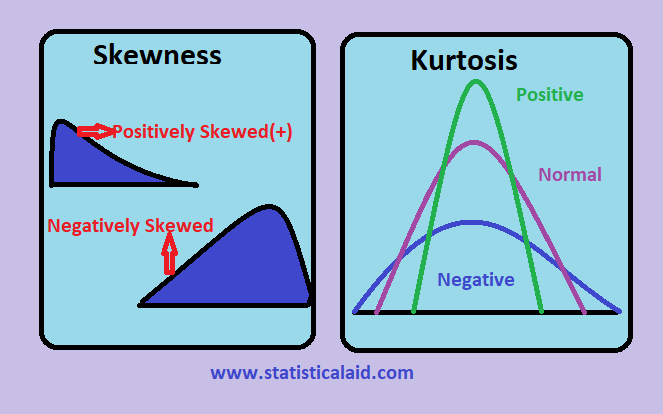



The next figures show the flexibility of the SHASH distribution in modelling various distributional forms. Note the effect of the two parameters, $\epsilon$ and $\delta$.

| Epsilon | Delta |
|---------|---------|
| 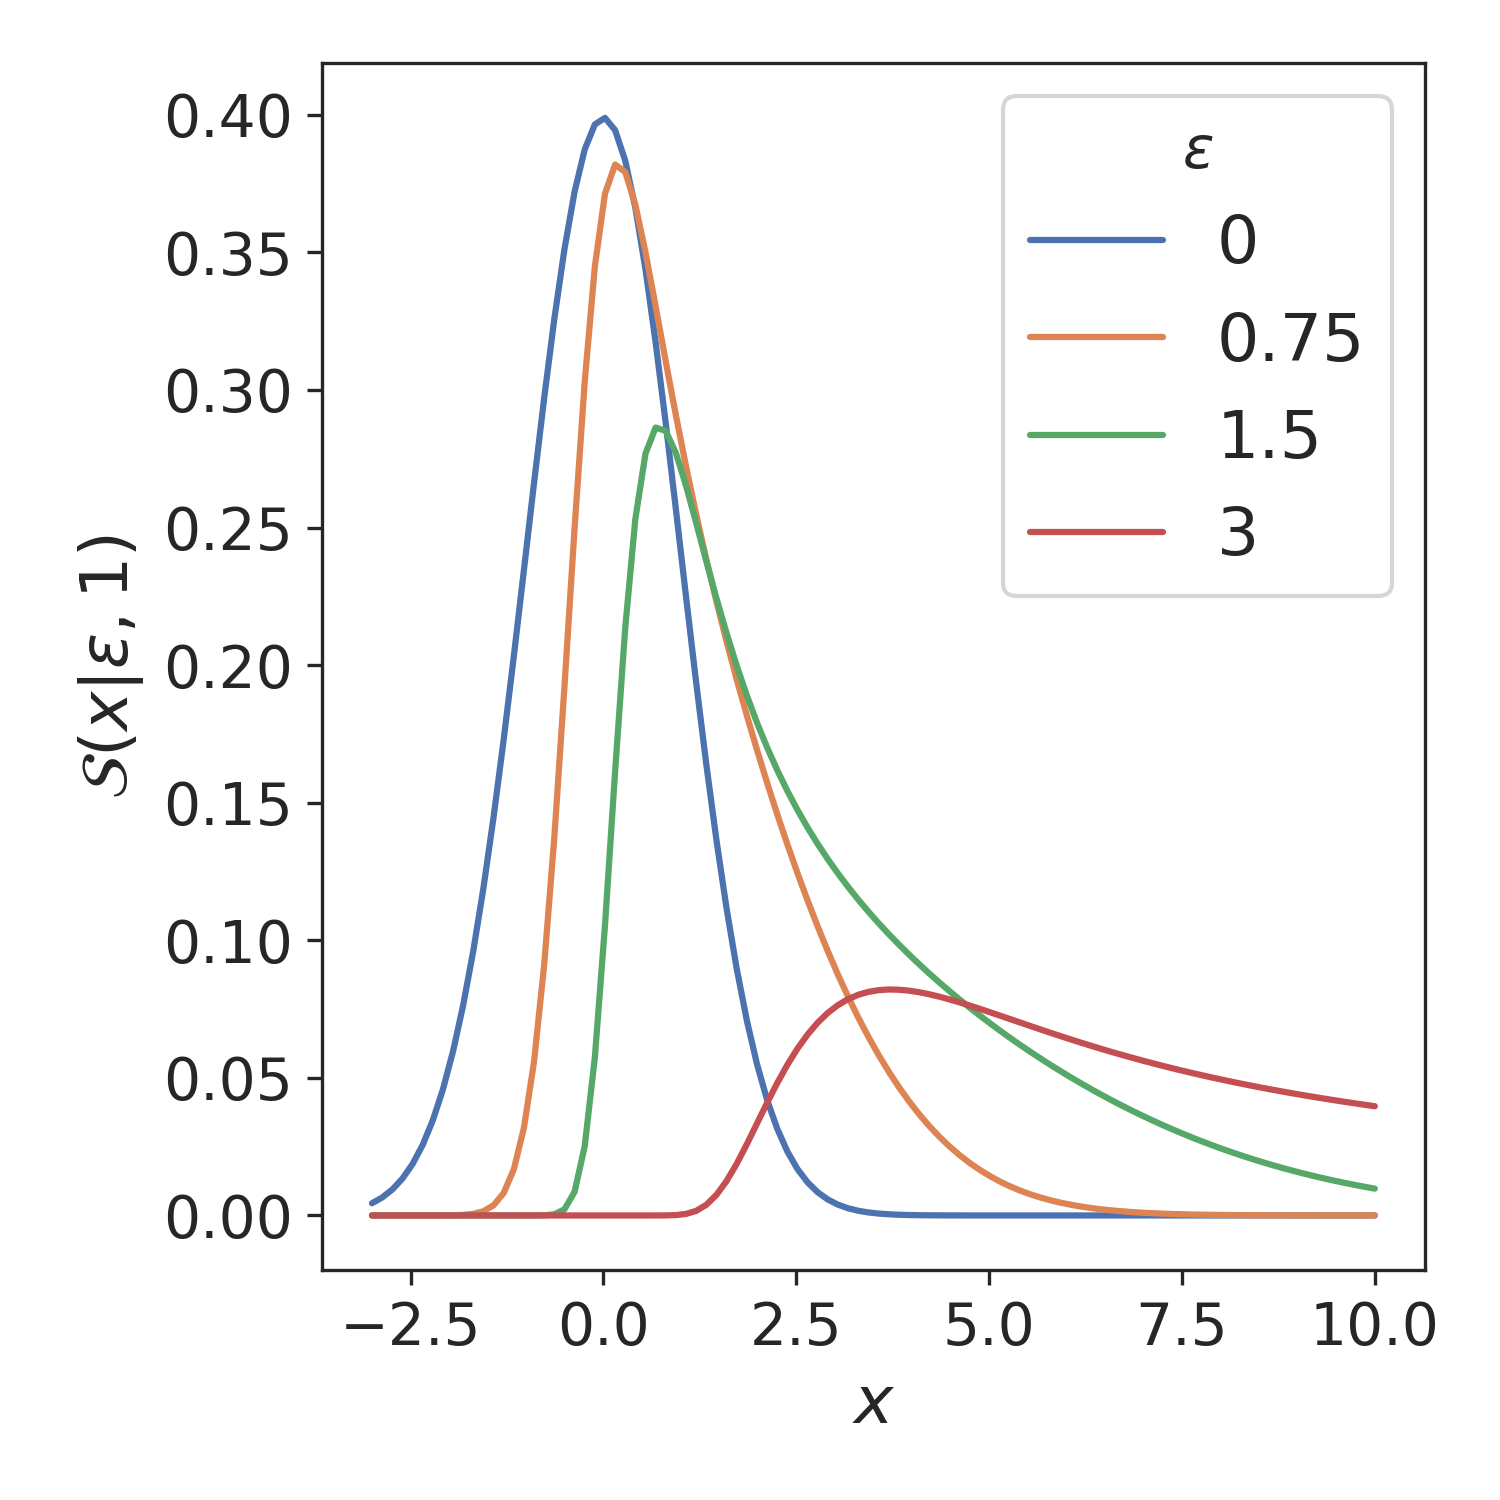 | 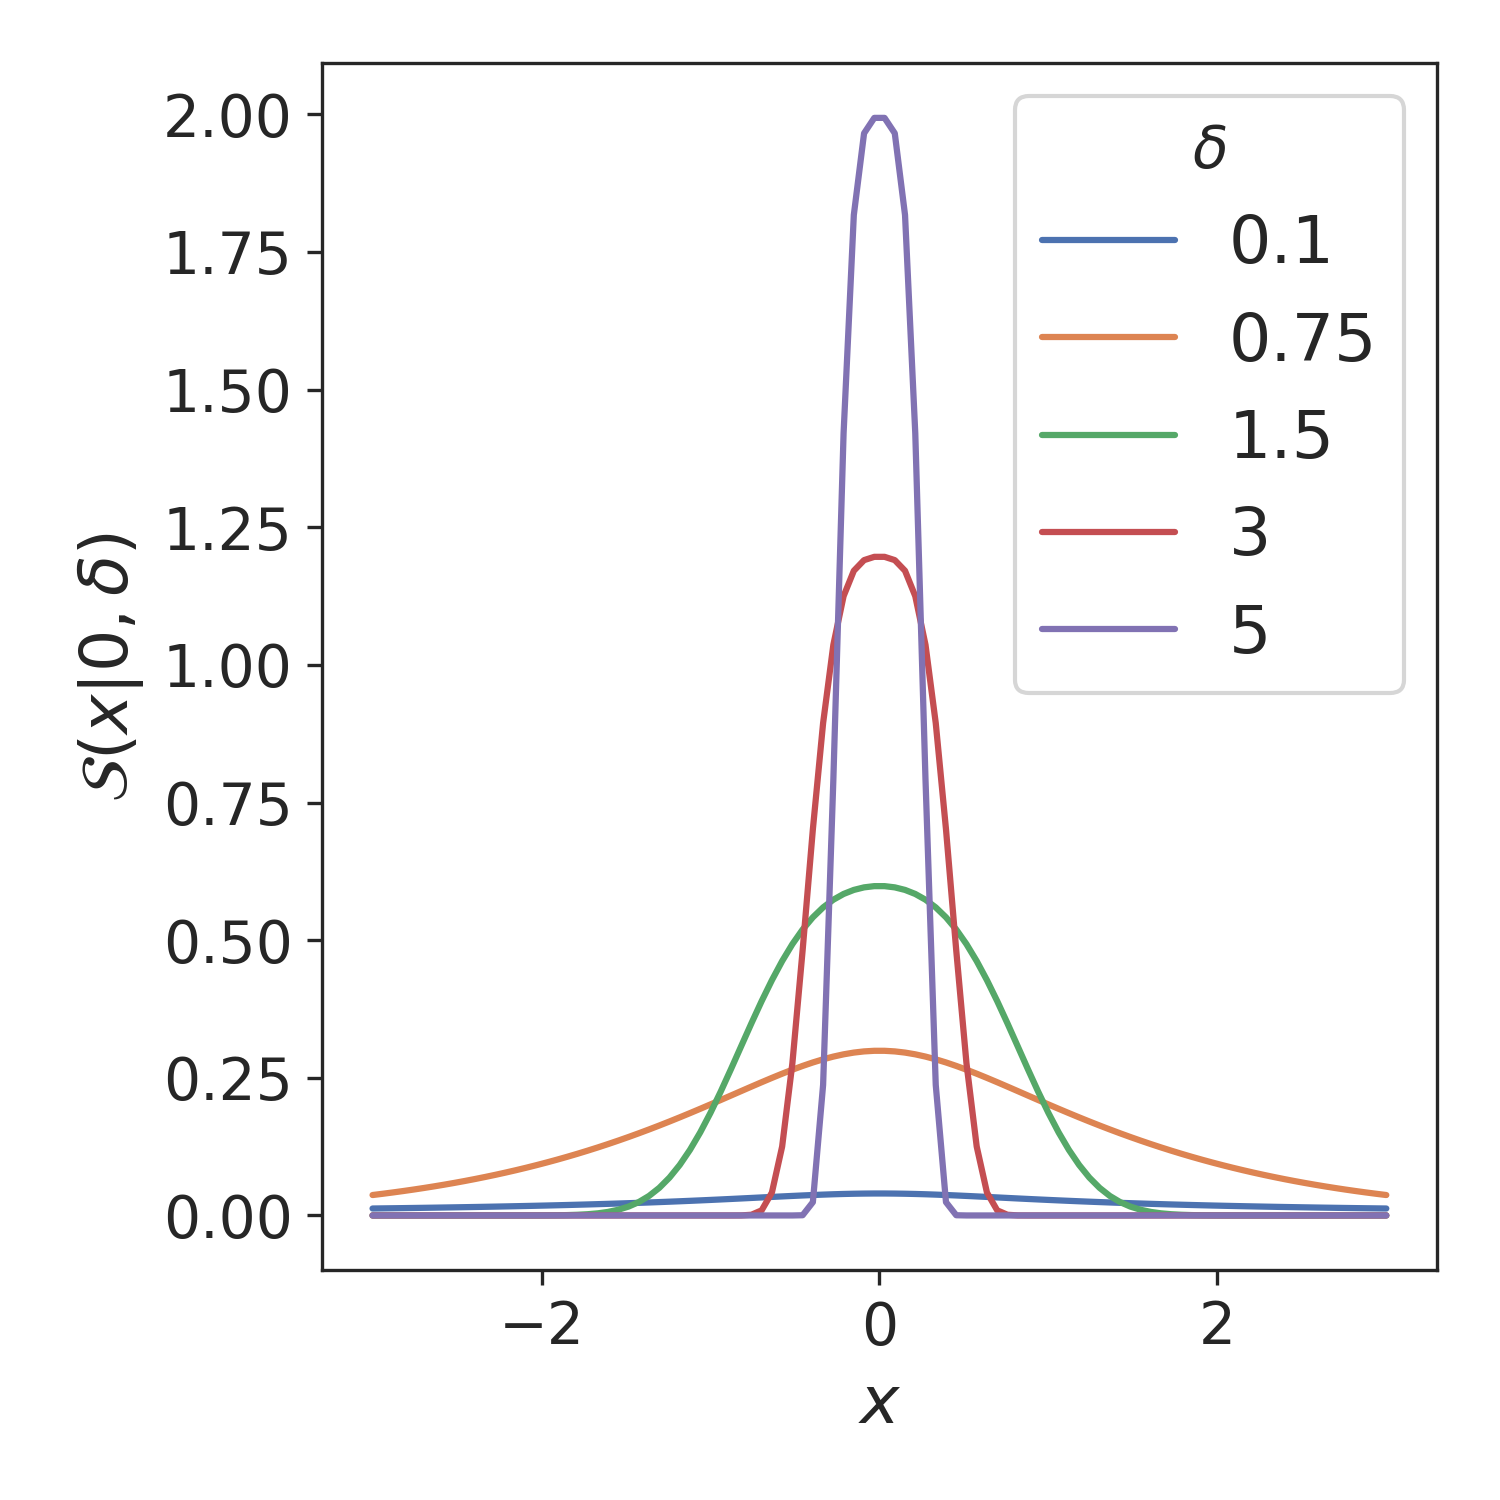 |


**Which parameters to regress on $\phi$**

Besides that, we also know that the measure of interest (model-based behaviour) tends to increase with age; it has a positive slope. Not only that, but the variance in the measure *also* tends to increase with age; as people get older, we have more uncertainty about their amount of model-based behaviour. From a modelling perspective, this means the variance also has a (potentially curved) slope. We decide to regress our variables controlling the mean ($\mu$) and variance ($\sigma$) on $\phi$. This indicates that we are not just predicting the expected value ($\mu$) of the dependent variable but also explicitly modelling how its variance ($\sigma$) changes. This is common in heteroskedastic models where variance is not assumed to be constant. Instead of modelling directly on $X$ the regression being done on $\phi$ transformed version derived from input features (such as polynomial or spline basis expansion) which allows more flexible modleling.

We could also fit a curve to the trajectories of $\epsilon$ and $\delta$, instead of keeping them fixed. This would result in a more complex model with a better fit, but it also makes more assumptions and it takes longer to fit. 


**Which basis expansion do we choose for $\phi$**

Furthermore, we know that these slopes are not straight lines, but rather curvy, so we choose a *bspline* basis expansion for $\phi$.

**How do we deal with batch-effects**

Our data is derived from images from several different studies. Each scanner has its own unique noise, as a sort of "fingerprint". This causes data from some studies to be consistently overestimated, or underestimated. Besides that, there tend to be consistent differences between male and female brains. To deal with this, we need to add a so-calld *random-effect* to the mean for each of the batches. This *random effect* gives each batch (site-scanner combination) it's own mean as a deviation from the group mean, i.e. the mean of all the means.

We could, but we do not add the random effect to the variance, skew, or kurtosis parameters, since we assume them to be the same for each site and sex. 

If we sample random effects, our sampler could have a hard time due to the so-called funnel effect which is explained [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/). We may decide to sample our random effects in a *non-centered* fashion to circumvent the funnel, but we decide not to here, for simplicity.

### Defining the model

First, let's deal with $\epsilon$ (skewness) and $\delta$ (kurtosis), since they are simple and modelled similarly.

Similar to $\mu$ (mean) in a Gaussian, $\epsilon$ (skewness) can be any real number, and we know it is 0 for non-skewed data, We also know that it controls the skew quite severly so we don't have to have a very wide prior. We decide to model it with a standard Gaussian

$$
\epsilon \sim \mathcal N(\epsilon \mid 0, 1)
$$

For $\delta$ (kurtosis), we need a positive real number, just like $\sigma$ (variance) in a Gaussian. We can model this with an inverse Gamma distribution, which is also commonly used as a prior for $\sigma$ (variance) in a Gaussian. We choose our prior such that the density close to 0 is negligible, because the SHASHb distribution becomes pathological when $\delta$ (kutosis) is very small. We also want the peak in our prior to be close to 1, because that is the neutral value for $\delta$ (kurtosis). Lastly, we want a moderate taiks to the right. This is achieved by letting $\delta$ be distributed like:

$$
\delta \sim \mathcal IG(\delta \mid 10,11)
$$

And here we see what that looks like: 

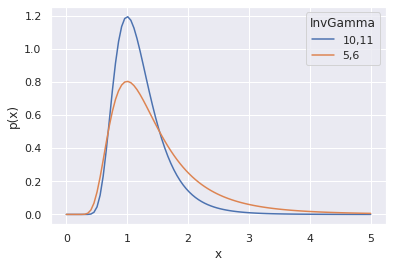



For the next parameter, $\sigma$ (sigma), we decided to go for a regression without random effects. We have to find weights for the slope, and an intercept. Because we don't have the random effect in $\sigma$ (sigma), these are also still quite easy. Assuming we standardised $Y$, and we standardised $X$ before creating $\phi$, we do not expect a very large slope, nor a very large intercept. Our slope $w_{\sigma}$ and our intercept $b_{\sigma}$ can both have a standard Gaussian prior.

We assume the weights $w_{\sigma}$ follow a D-dimensional isotropic Gaussian distribution, meaning each weight has a mean of zero and an identity covariance matrix:

$$
w_{\sigma} \sim \mathcal{N} (w_{\sigma} \mid \mathbf{0}^D, \mathbf{I}^{D \times D})
$$

**Example:**
Let’s say we have **4 input features** in our regression model:

- *Age*  
- *IQ score*
- *Reaction time* 
- *Memory performance*

Then, our weight vector might look like this (**D = 4**):  

$$
w_{\sigma} = [0.2, -0.5, 1.1, 0.3]
$$

Each number in this vector tells us how strongly its corresponding feature affects \( \sigma \).

The intercept $b_{\sigma}$ is also normally distributed but with a simpler Gaussian prior:

$$
b_{\sigma} \sim \mathcal{N} (b_{\sigma}\mid \mathbf 0, 1)
$$


We do have to take care that $\sigma$ is non-negative, which we can do by applying a softplus to the output of the regression. The softplus function is defined as: $softplus(x) = log(exp(x)+1)$, and it looks like this:

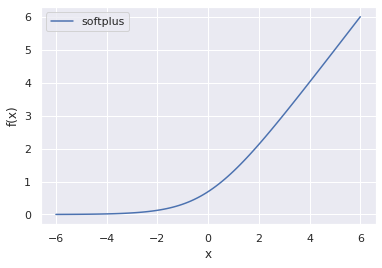

For negative $x$, the softplus is almost 0. For positive $x$, the softplus is almost $x$. However, the softplus is smooth and differentiable, which is nice if we want to sample with NUTS later. The $\sigma$ that we find for the $nth$ datapoint is then given by:

$$
\sigma_{n} = \text{softplus}(\phi_{n}w_{\sigma} + b_{\sigma}) \quad  n \in \{1, \dots, N\}
$$

Last but not least, we need to define a $mu_{n}$ for each $n \in {1,...,N}$. We decide to regress on $\phi$, and add a random effect o fthe *intercept*, because the batch effects are assumed to be constant over all ages. To simplify notation, for the next paragraph, you can read $b$ as $b_{\mu}$, so $b_{\mu}$ for the $n$'th datapoint is written as $b_{n}$. 

The intercept (with batch effect) is defined like this:

$$ \sigma_{bi} \sim \mathcal IG(\sigma_{bi} \mid \mathbf 5,6) \quad  n \in \{1, \dots, B\} $$

$$ \sigma_{b} \sim \mathcal N(\mu_{b} \mid \mathbf 0,1) $$

$$ b_{n} \sim \mathcal N(b_{n} \mid \mathbf \mu_{b}, \sigma_{bz_{n}}) $$

Here we see that each batch effects gets its own offset $\sigma_{bi}$ from the group mean $\mu_{b}$. The correct $\sigma_{b}$ is selected for each datapoint using the indices in $Z$. The slope is almost identical to that for $\sigma$

$$
w_{\mu} \sim \mathcal{N} (w_{\mu} \mid \mathbf{0}^D, \mathbf{I}^{D \times D})
$$

which leads to $\mu_{n}$ given by:

$$
\mu_{n} = \phi_{n}w_{\mu}+b_{\mu}
$$

Finally, we have the likelihood:

$$
y_{n} = SHASHb(y_{n}\mid \mathbf \mu_{n}, \sigma_{n}, \epsilon, \delta)
$$



In [2]:
# Load data
MB_data = pd.read_csv("PCN_data.csv")


In [3]:
# create working dir
tutdir = os.getcwd()
processing_dir = "HBR_tutorial_wdir/"
if not os.path.isdir(processing_dir):
    os.makedirs(processing_dir)
os.chdir(processing_dir)
processing_dir = os.getcwd()
print(f"The processing directory is: {processing_dir}")

The processing directory is: /Users/mariapitteri/Library/Mobile Documents/com~apple~CloudDocs/Birkbeck_Job/Data/Normative_Modelling/PCN/HBR_tutorial_wdir


### Prepare the data

- Response variable: the MB
- Covariate: age
- Batch effects: gender and experiment location

In [4]:
MB_data['experiment'] = MB_data['experiment'].replace({'exp_1': 0, 'exp_2': 1}).astype(int)
MB_data['gender'] = MB_data['experiment'].replace({'-1': 0, '1': 1}).astype(int)
MB_data

/var/folders/ct/0_d4gmxn61q_ct7w3flq64mw0000gn/T/ipykernel_33182/3759744247.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  MB_data['experiment'] = MB_data['experiment'].replace({'exp_1': 0, 'exp_2': 1}).astype(int)


,age,lastWinRew_lastTranUnc,oci_total,gender,experiment
0,52,0.006037,14,0,0
1,32,0.484809,28,0,0
2,26,0.464784,2,0,0
3,24,-0.140624,25,0,0
4,59,0.277459,21,0,0
...,...,...,...,...,...
1956,24,0.205950,13,1,1
1957,23,0.394566,23,1,1
1958,20,0.166920,38,1,1
1959,24,0.836057,4,1,1


In [5]:
# Prepare the covariate and response data

# Extract the relevant columns of the data frame (age as a covariate and oci_total as a response)
covariates = pd.DataFrame(MB_data['age'])
response = pd.DataFrame(MB_data['lastWinRew_lastTranUnc'])
be_gender = pd.DataFrame(MB_data['gender'])
be_exp = pd.DataFrame(MB_data['experiment'])

# Split the data into training and testing sets

X_train, X_test, y_train, y_test, be_gender_train, be_gender_test, be_exp_train, be_exp_test = train_test_split(covariates, response, be_gender, be_exp, test_size=0.2, random_state=42)


In [6]:
# verify that training and test arrays are the same size

tr_cov_size = X_train.shape
tr_resp_size = y_train.shape
tr_be_gender_size = be_gender_train.shape
tr_be_exp_size = be_exp_train.shape

te_cov_size = X_test.shape
te_resp_size = y_test.shape
te_be_gender_size = be_gender_test.shape
te_be_exp_size = be_exp_test.shape

print("Train covariate size is: ", tr_cov_size)
print("Test covariate size is: ", te_cov_size)
print("Train response size is: ", tr_resp_size)
print("Test response size is: ", te_resp_size)
print("Train Gender batch effect is: ", tr_be_gender_size)
print("Test Gender batch effect is: ", te_be_gender_size)
print("Train Experiment batch effect is: ", tr_be_exp_size)
print("Test Experiment batch effect is: ", te_be_exp_size)

Train covariate size is:  (1568, 1)
Test covariate size is:  (393, 1)
Train response size is:  (1568, 1)
Test response size is:  (393, 1)
Train Gender batch effect is:  (1568, 1)
Test Gender batch effect is:  (393, 1)
Train Experiment batch effect is:  (1568, 1)
Test Experiment batch effect is:  (393, 1)


In [7]:
# Merge batch effects df
be_tr = pd.concat([be_gender_train, be_exp_train], axis=1)
be_te = pd.concat([be_gender_test, be_exp_test], axis=1)

Z_train = be_tr[['gender','experiment']].to_numpy(dtype=float)
Z_test = be_te[['gender','experiment']].to_numpy(dtype=float)

In [8]:
# Correct format for Normative Model

X_train=X_train['age']
y_train=y_train['lastWinRew_lastTranUnc']


X_test=X_test['age']
y_test=y_test['lastWinRew_lastTranUnc']




# Convert data to the correct format for the estimate function

# Define file names for pickle files
covariates_train_file = 'X_train.pkl'
response_train_file = 'y_train.pkl'

covariates_test_file = 'X_test.pkl'
response_test_file = 'y_test.pkl'

be_train_file = 'trbefile.pkl'
be_test_file = 'tsbefile.pkl'

# Save training data as pickle
with open(covariates_train_file, 'wb') as f:
    pickle.dump(X_train, f)

with open(response_train_file, 'wb') as f:
    pickle.dump(y_train, f)

# Save testing data as pickle
with open(covariates_test_file, 'wb') as f:
    pickle.dump(X_test, f)

with open(response_test_file, 'wb') as f:
    pickle.dump(y_test, f)


# Save testing data as pickle
with open(be_train_file, 'wb') as f:
    pickle.dump(be_tr, f)

with open(be_test_file, 'wb') as f:
    pickle.dump(be_te, f)

In [9]:
respfile = os.path.join(processing_dir, 'Y_train.pkl')       # measurements  (eg cortical thickness) of the training samples (columns: the various features/ROIs, rows: observations or subjects)
covfile = os.path.join(processing_dir, 'X_train.pkl')        # covariates (eg age) the training samples (columns: covariates, rows: observations or subjects)

testrespfile_path = os.path.join(processing_dir, 'Y_test.pkl')       # measurements  for the testing samples
testcovfile_path = os.path.join(processing_dir, 'X_test.pkl')        # covariate file for the testing samples

trbefile = os.path.join(processing_dir, 'trbefile.pkl')      # training batch effects file (eg scanner_id, gender)  (columns: the various batch effects, rows: observations or subjects)
tsbefile = os.path.join(processing_dir, 'tsbefile.pkl')      # testing batch effects file

output_path = os.path.join(processing_dir, 'Models/')        # output path, where the models will be written
if not os.path.isdir(output_path):
    os.mkdir(output_path)
    
log_dir = os.path.join(processing_dir, 'log/')               # log path, where the log is written
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

outputsuffix = '_estimate'  

In [10]:
likelihood = 'SHASHb'
model_type='bspline'
linear_mu='True'
random_mu='False'
random_slope_mu='False'
random_intercept_mu='True'
centered_intercept_mu='True'
linear_sigma='True'
random_intercept_sigma='False'
inscaler_type='standardize'
outscaler_type='standardize'

inscaler = ptk.util.utils.scaler(inscaler_type)
X_train_standardized = inscaler.fit_transform(X_train)
X_test_standardized = inscaler.transform(X_test)

outscaler = ptk.util.utils.scaler(outscaler_type)
Y_train_standardized = outscaler.fit_transform(y_train)
Y_test_standardized = outscaler.transform(y_test)

Then we just need to specify how many MCMC chains we want, and how many samples per chain we want. Let's go for a NUTS sampler with 4 chains of 1500 sampless, and 500 tuning samples. We also give our sampler 16 cores, since that will speed things up a lot. Besides that, we set target_accept to 0.9, since we otherwise get complaints from PyMC3. It is not uncomming to increase target_accept for posteriors with more complex forms, like ours.

In [11]:
n_mcmc_samples = 1500
n_tuning_samples = 500
n_chains = 4
n_cores = 16
target_accept = 0.99

Of course, we want to use the hbr algorithm, and save the output and our model. We set the keyword binary='True' to store in pkl format.



In [12]:
alg='hbr'
saveoutput='True'
savemodel='True'
binary='True'

We can now make the call to the fit function. Beware that this may take a while, depending on your computer.



In [13]:
ptk.normative.fit(covfile=covfile,
                       respfile=respfile,
                       trbefile=trbefile,
                       testcov= testcovfile_path,
                       testresp = testrespfile_path,
                       tsbefile=tsbefile,
                       log_path=log_dir,
                       saveoutput=saveoutput,
                       output_path=output_path, 
                       savemodel=savemodel,
                       binary=binary,
                       outputsuffix=outputsuffix,
                       alg=alg,
                       n_samples=n_mcmc_samples,
                       n_tuning=n_tuning_samples,
                       n_chains=n_chains,
                       cores=n_cores,
                       target_accept=target_accept,
                       inscaler=inscaler_type,
                       outscaler=outscaler_type,
                       likelihood=likelihood,
                       model_type=model_type,
                       linear_mu=linear_mu,
                       random_mu=random_mu,
                       random_slope_mu = random_slope_mu,
                       random_intercept_mu=random_intercept_mu,
                       centered_intercept_mu=centered_intercept_mu,
                       linear_sigma=linear_sigma,
                       random_intercept_sigma=random_intercept_sigma
                 )

inscaler: standardize
outscaler: standardize
Processing data in /Users/mariapitteri/Library/Mobile Documents/com~apple~CloudDocs/Birkbeck_Job/Data/Normative_Modelling/PCN/HBR_tutorial_wdir/Y_train.pkl
Estimating model  1 of 1


Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


/opt/anaconda3/envs/PCN/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 1249 seconds.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Saving model meta-data...


### Evaluate the model
### Convergence
### R statistic
The Rstatistic says something about the convergence of the sampling process. Roughly speaking, you could say that when the variance within the chains is almost the same as the variance between the chains, the chains have all converged to the same distribution. We want 
to converge to 1, but if it's lower than 1.1, that's already pretty good. If we have everything stable below 1.05, we have a reason to be happy. However, we should always check our chains for weird instabilities.

In [14]:
# Load the model and show the idata (the object that contains the MCMC samples)
model_path = os.path.join(output_path, f'NM_0_0{outputsuffix}.pkl')
nm = pickle.load(open(model_path,'rb'))
nm.hbr.idata.posterior

<xarray.Dataset> Size: 1MB
Dimensions:             (chain: 4, draw: 1500, basis_functions: 6,
                         batch_effect_0: 2, batch_effect_1: 2,
                         datapoints: 1568, empty: 1)
Coordinates:
  * chain               (chain) int64 32B 0 1 2 3
  * draw                (draw) int64 12kB 0 1 2 3 4 ... 1495 1496 1497 1498 1499
  * basis_functions     (basis_functions) int64 48B 0 1 2 3 4 5
  * batch_effect_0      (batch_effect_0) int16 4B 0 1
  * batch_effect_1      (batch_effect_1) int16 4B 0 1
  * datapoints          (datapoints) int64 13kB 0 1 2 3 ... 1564 1565 1566 1567
  * empty               (empty) int64 8B 0
Data variables: (12/14)
    slope_mu            (chain, draw, basis_functions) float64 288kB -0.2799 ...
    mu_intercept_mu     (chain, draw) float64 48kB 1.095 0.9857 ... 8.142 8.252
    intercept_mu        (chain, draw, batch_effect_0, batch_effect_1) float64 192kB ...
    slope_sigma         (chain, draw, basis_functions) float64 288kB -2.559 ....
    intercept_sigma     (chain, draw) float64 48kB -18.97 -19.22 ... -25.86
    epsilon             (chain, draw) float64 48kB 0.4229 0.3914 ... 0.4189
    ...                  ...
    mu_samples          (chain, draw, empty) float64 48kB 0.0 0.0 ... 0.0 0.0
    sigma_samples       (chain, draw, empty) float64 48kB 0.0 0.0 ... 0.0 0.0
    sigma_plus_samples  (chain, draw, empty) float64 48kB 0.0 0.0 ... 0.0 0.0
    epsilon_samples     (chain, draw, empty) float64 48kB 0.0 0.0 ... 0.0 0.0
    delta_samples       (chain, draw, empty) float64 48kB 0.0 0.0 ... 0.0 0.0
    delta_plus_samples  (chain, draw, empty) float64 48kB 0.0 0.0 ... 0.0 0.0
Attributes:
    created_at:                 2025-02-19T16:44:17.394883+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              1249.1166369915009
    tuning_steps:               500

arviz - WARNING - Shape validation failed: input_shape: (4, 0), minimum_shape: (chains=2, draws=4)


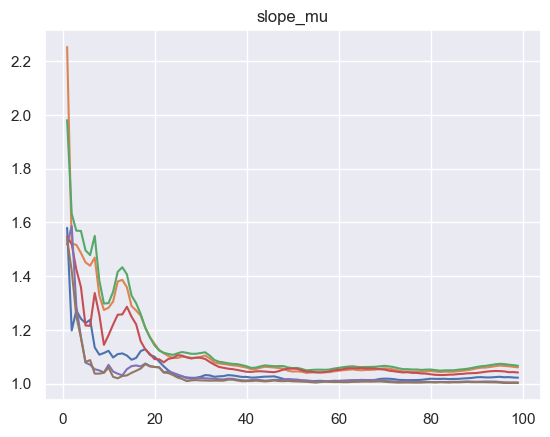

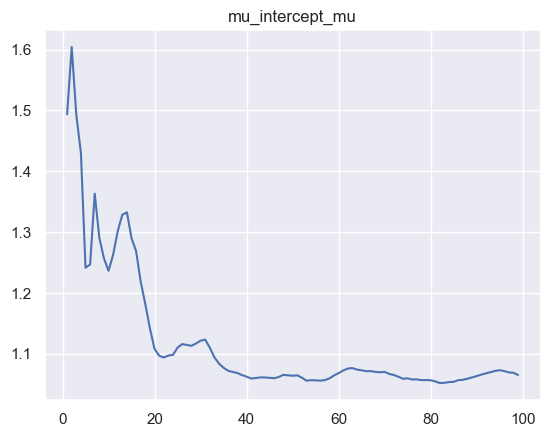

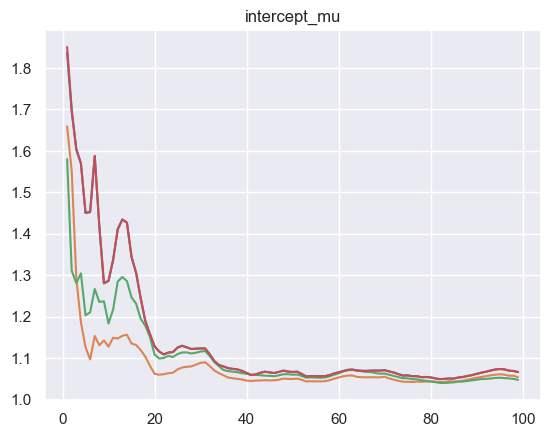

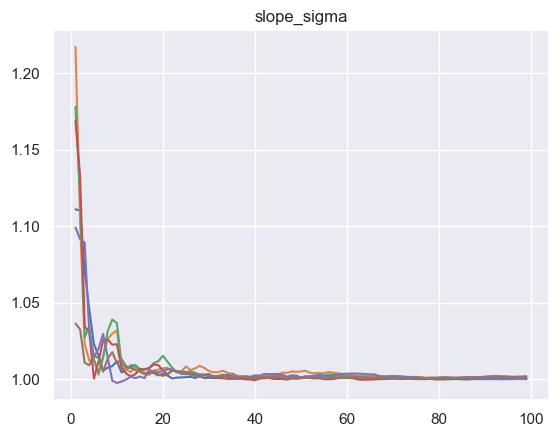

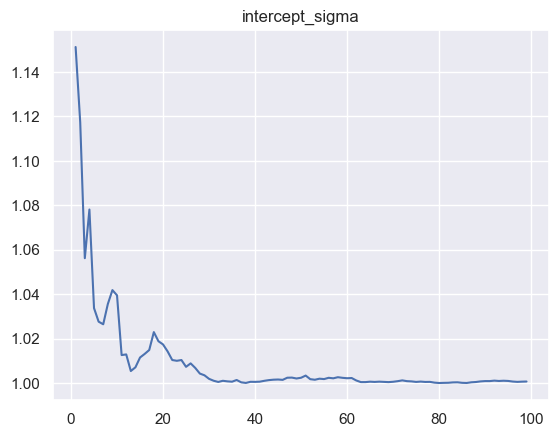

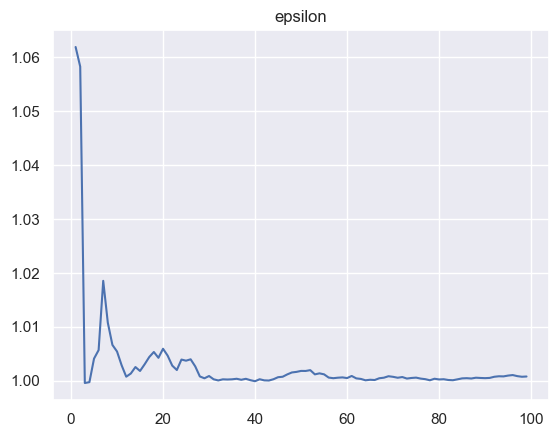

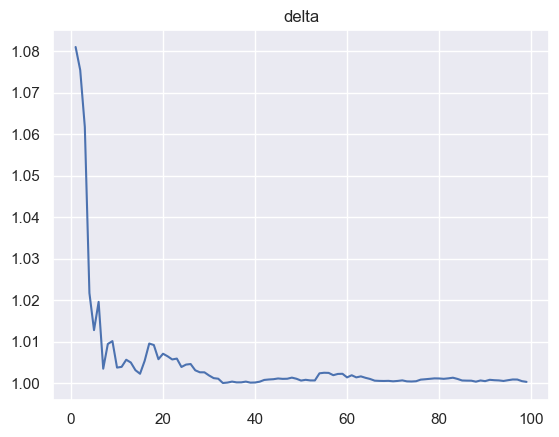

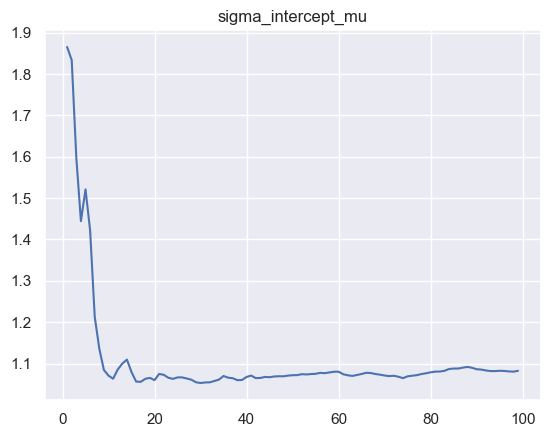

In [15]:
Rhat = nm.hbr.Rhats()
for r in Rhat.keys():
    plt.plot(Rhat[r])
    plt.title(r)
    plt.show()


Sample Correlations
If parameters are very correlated in the posterior, our sampler may have a hard time. We make a dataframe of all the parameters samples, so that we can inspect their correlation.

In [16]:

nm = pickle.load(open(model_path,'rb'))
posterior = az.extract(nm.hbr.idata)
# nm.hbr.trace['epsilon']
paramdf = pd.DataFrame()
for v in posterior.keys():
    flattened = np.reshape(posterior[v].data, (posterior[v].data.shape[-1],-1))
    if flattened.shape[1]>1:
        for i in range(flattened.shape[1]):
            paramdf[f'{v}_{i}'] = flattened[:,i]
    else:
        paramdf[f'{v}'] = flattened[:,0]

/opt/anaconda3/envs/PCN/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/PCN/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


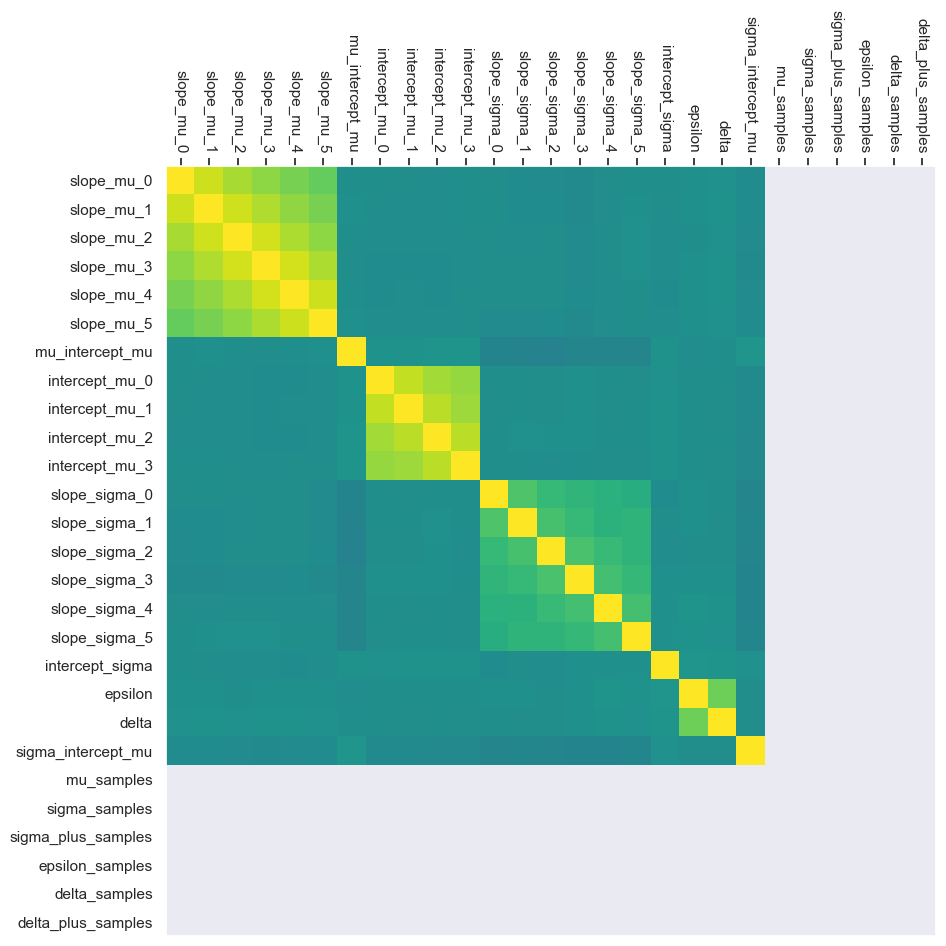

In [17]:

l = np.stack(paramdf.values, axis = 1)
c = np.corrcoef(l)
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.grid(False)
plt.imshow(c, vmin = -1, vmax = 1, cmap = 'viridis')
plt.xticks(np.arange(len(paramdf.keys())),paramdf.keys(), rotation = -90)
ax.xaxis.tick_top()

plt.yticks(np.arange(len(paramdf.keys())),paramdf.keys())

plt.show()

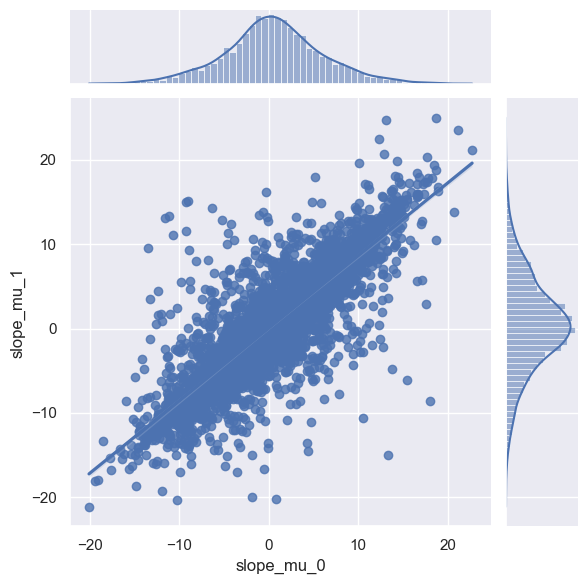

In [18]:
sns.jointplot(x=f'slope_mu_0', y = f'slope_mu_1',data=paramdf ,kind='reg')
plt.show()

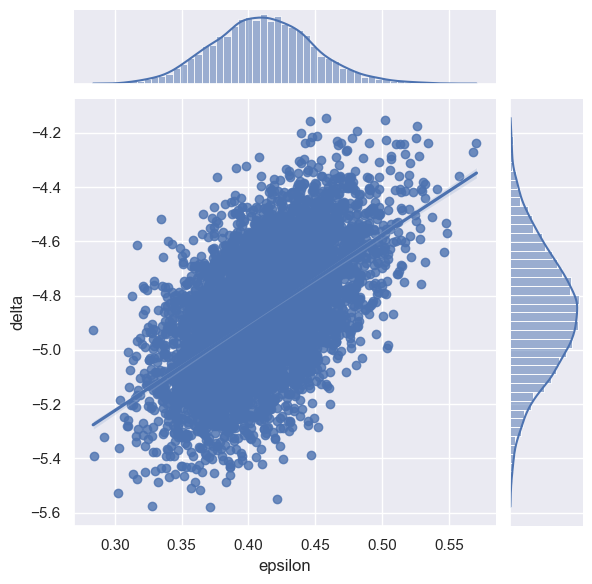

In [19]:

i=3
sns.jointplot(x=f'epsilon', y = f'delta',data=paramdf ,kind='reg')
plt.show()

In [20]:
# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
X_test_standardized_np = np.array(X_test_standardized)[:,np.newaxis]
# Same goes for Y_test_standardized, because we only have a single dependent variable, we need to expand to obtain a second dimension of 1.
Y_test_standardized_np = np.array(Y_test_standardized)[:,np.newaxis]
# We need to convert the Z_test to integers, because the model expects integers.
Z_test2 = Z_test.astype(int)

# The model accepts the path to the Z_test file, so we need to save it first.
with open('tsbefile2.pkl', 'wb') as file:
    pickle.dump(pd.DataFrame(Z_test2), file)
# Then we generate the path.
tsbefile2 = os.path.join(processing_dir, 'tsbefile2.pkl') 

# We can now use the get_mcmc_zscores function to obtain the z-scores.
zs = nm.get_mcmc_zscores(X_test_standardized_np, Y_test_standardized_np, tsbefile=tsbefile2)


SHASHb


Sampling: [y_like]


/opt/anaconda3/envs/PCN/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

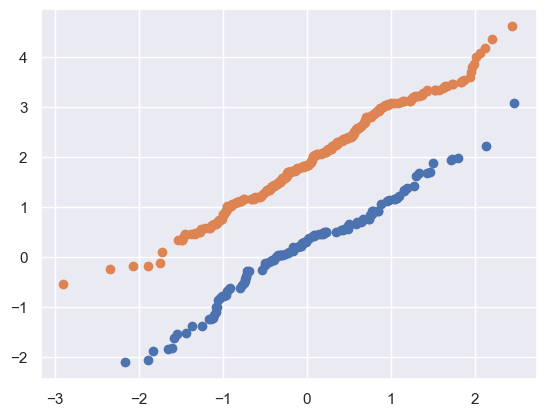

In [21]:
bes = np.unique(Z_test, axis = 0)
for ibe, be in enumerate(bes):
    idx = (Z_test == be).all(1)
    this_zs = zs[idx]
    zs_sorted = np.sort(this_zs)
    ns = np.random.randn(this_zs.shape[0])
    plt.scatter(np.sort(ns), zs_sorted+2*ibe)

Quantile Plots

In [27]:

# Get the MCMC-estimated quantiles
minx = np.min(X_train_standardized)
maxx = np.max(X_train_standardized)

zscores = np.arange(-3,4)

# We need to provide a matrix of shape [N,d]. In this case d=1, so we need to expand this matrix with a single 'empty' dimension.
# We can do this by using the np.newaxis in this way.
n_synthetic_samples = 200
synthetic_X = np.linspace(minx, maxx, n_synthetic_samples)

be = np.zeros((n_synthetic_samples,2))
q  = nm.get_mcmc_quantiles(synthetic_X,  be,zscores)

Sampling: [y_like]


/opt/anaconda3/envs/PCN/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
# plot the quantiles
plt.scatter(X_train, Y_train, s = 4, alpha = 0.4)
for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    plt.plot(inscaler.inverse_transform(synthetic_X), outscaler.inverse_transform(q[i]), linewidth = thickness, linestyle = linestyle, color = 'black', alpha = 0.7)


In [ ]:
print(len(synthetic_X))
print(be.shape[0])
zscores.shape

200
200


(7, 1)

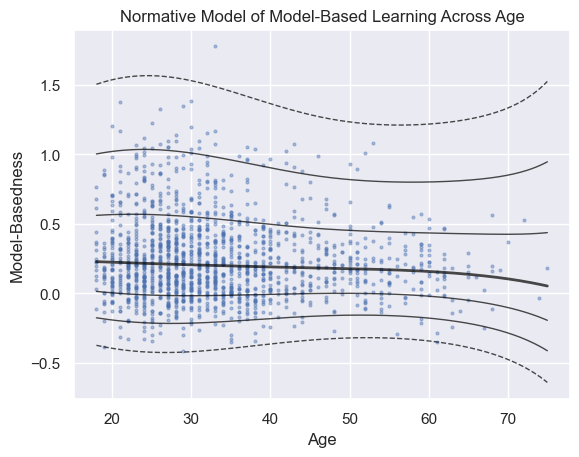

In [29]:
# Plot the quantiles
plt.scatter(X_train, y_train, s=4, alpha=0.4, label="Training Data")

for i, v in enumerate(zscores):
    thickness = 1
    linestyle = "-"
    if v == 0:
        thickness = 2
    if abs(v) > 2:
        linestyle = "--"
    
    plt.plot(
        inscaler.inverse_transform(synthetic_X), 
        outscaler.inverse_transform(q[i]), 
        linewidth=thickness, 
        linestyle=linestyle, 
        color='black', 
        alpha=0.7
    )

# Add axis labels and title
plt.xlabel("Age")
plt.ylabel("Model-Basedness")
plt.title("Normative Model of Model-Based Learning Across Age")

# Show the plot
plt.show()
